<h1 align="center">Deep Learning - Master in Deep Learning of UPM</h1> 

**IMPORTANTE**

Antes de empezar debemos instalar PyTorch Lightning, por defecto, esto valdría:

In [ ]:
!pip install pytorch-lightning

Además, si te encuentras ejecutando este código en Google Collab, lo mejor será que montes tu drive para tener acceso a los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


DATA_PATH = 'data/stocks.csv'
SEED = 42
seed_everything(seed=SEED) # Fijamos una semilla para reproducibilidad en los experimentos

Seed set to 42


42

Ya sabemos como atacar mediante el uso de Redes Neuronales Recurrentes un problema univariable de series temporales. En este ejercicio práctico subiremos algo el nivel enfrentándonos a un clásico problema de stock prediction. Utilizaremos técnicas similares para predecir el valor futuro de diversas acciones.

Nuestra variable objetivo será el precio de cierre de cierta acción en el futuro (Close), sin embargo, ahora tenemos otras variables que representan como ha evolucionado el precio en el transcurso de un día, como son:
- Open: en qué precio abrió
- Close: en qué precio cerró
- High: el valor más alto en el día
- Low: el valor más bajo en el día

Como ya hemos visto, en series temporales, la misma variable puede ser a la vez inputs y etiquetas, siempre y cuando difieran temporalmente.

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df[df['Name'] == 'AMZN']



In [12]:
df = pd.read_csv(DATA_PATH)
df = df[df['Name'] == 'AMZN']

df.head() # Imprimamos las primeras filas del dataframe

,Date,Open,High,Low,Close,Name
87574,03/01/2006,47.47,47.85,46.25,47.58,AMZN
87575,04/01/2006,47.48,47.73,46.69,47.25,AMZN
87576,05/01/2006,47.16,48.20,47.11,47.65,AMZN
87577,06/01/2006,47.97,48.58,47.32,47.87,AMZN
87578,09/01/2006,46.55,47.10,46.40,47.08,AMZN


En este dataset hay muchas empresas (AMZN, GOOGL, IBM), coged la que consideréis más interesante ([más información](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data)).

In [13]:
data = pd.read_csv(DATA_PATH)
data = data[data['Name'] == 'AMZN']
data = data.drop(columns=['Name'])

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.sort_values('Date', inplace=True)
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")

Date range: 2006-01-03 00:00:00 to 2017-12-29 00:00:00


Construye un Dataset que reciba la compañía sobre la que se va a entrenar, el tamaño de ventana y de horizonte

In [14]:
class StocksDataset(torch.utils.data.Dataset):
    def __init__(self, df, w=10, h=1):
        self.data = df.drop(['Date', 'Name'], axis=1).values
        self.target = df['Volume'].values
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data) - (self.w + self.h) + 1

    def __getitem__(self, idx):
        features = self.data[idx:idx+self.w] # [i: i+w)
        target = self.target[idx+self.w: idx+self.w+self.h] # [i+w, i+w+h)
        return features, target

Para seguir, el siguiente código no debe dar error ninguno

In [46]:
comp = 'AMZN'
w = 10
h = 3

df = pd.read_csv(DATA_PATH)
df = df[df['Name'] == comp]
dataset = StocksDataset(df, w=w, h=h)

sample = dataset[0]

assert len(sample) == 2 # Comprobamos que el dataset devuelve dos elementos
assert sample[0].shape == (w, 5) # Comprobamos que las features tienen la forma correcta
assert sample[1].shape == (h,) # Comprobamos que el target tiene la forma correcta

Ya podemos crear el DataModule

In [80]:
class SalesDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self, df, comp='AMZN', w=10, h=1, batch_size=16, val_size=0.2, test_size=0.2):
        super().__init__()
        
        df = df[df['Name'] == comp]
        self.train_df, self.val_df, self.test_df = self.sequential_train_val_test_split(df, val_size=val_size, test_size=test_size)
        # self.price_scaler, self.volume_scaler = self.normalize()

        self.comp = comp
        self.w = w
        self.h = h

        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = StocksDataset(self.train_df, w=self.w, h=self.h)
            self.val_dataset = StocksDataset(self.val_df, w=self.w, h=self.h)
        elif stage == 'test':
            self.test_dataset = StocksDataset(self.test_df, w=self.w, h=self.h)

    def sequential_train_val_test_split(self, df, val_size=0.2, test_size=0.2):
        # Aseguramos el formate de la fecha y ordenamos por ella
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
        df.sort_values('Date', inplace=True)

        # Calculamos los índices para hacer los splits
        n = len(df)
        train_end = int((1 - val_size - test_size) * n)
        val_end = int((1 - test_size) * n)

        train = df.iloc[:train_end].copy()
        val = df.iloc[train_end:val_end].copy()
        test = df.iloc[val_end:].copy()

        return train, val, test
    
    # Tendremos dos scalers, uno para los precios y otro para el volumen ya que son dos magnitudes distintas
    def normalize(self):
        # Identify columns
        price_cols = ['Open', 'High', 'Low', 'Close']
        volume_col = ['Volume']

        # Non-scaled columns
        train_non_scaled = self.train_df[['Date', 'Name']]
        val_non_scaled = self.val_df[['Date', 'Name']]
        test_non_scaled = self.test_df[['Date', 'Name']]

        # Fit scaler for prices
        price_scaler = MinMaxScaler()
        price_scaler.fit(self.train_df[price_cols])
        
        # Fit scaler for volume separately
        volume_scaler = MinMaxScaler()
        volume_scaler.fit(self.train_df[volume_col])

        # Scale train
        train_prices = price_scaler.transform(self.train_df[price_cols])
        train_volume = volume_scaler.transform(self.train_df[volume_col])

        # Scale val
        val_prices = price_scaler.transform(self.val_df[price_cols])
        val_volume = volume_scaler.transform(self.val_df[volume_col])

        # Scale test
        test_prices = price_scaler.transform(self.test_df[price_cols])
        test_volume = volume_scaler.transform(self.test_df[volume_col])

        # Reconstruct the DataFrames
        scaled_train = pd.DataFrame(train_prices, columns=price_cols, index=self.train_df.index)
        scaled_train['Volume'] = train_volume

        scaled_val = pd.DataFrame(val_prices, columns=price_cols, index=self.val_df.index)
        scaled_val['Volume'] = val_volume

        scaled_test = pd.DataFrame(test_prices, columns=price_cols, index=self.test_df.index)
        scaled_test['Volume'] = test_volume

        self.train_df = pd.concat([train_non_scaled, scaled_train], axis=1)
        self.val_df = pd.concat([val_non_scaled, scaled_val], axis=1)
        self.test_df = pd.concat([test_non_scaled, scaled_test], axis=1)

        # Store scalers if you want to invert transform later
        self.price_scaler = price_scaler
        self.volume_scaler = volume_scaler

        return self.price_scaler, self.volume_scaler
    
    def collate_fn(self, batch):
        features, targets = zip(*batch)

        features = np.stack(features, axis=0)  # [batch_size, w, input_size]
        targets = np.stack(targets, axis=0)    # [batch_size, h, input_size]

        features = torch.tensor(features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        return features, targets
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

A continuación creemos nuestro modelo de regresión temporal basado en una RNN. La diferencia con el que hemos aprendido en clase será que este reciba un argumento extra _pooling_[str] que podrá tomar tres valores y actuar en consecuencia:

- _pooling_ = "last" -> tomará la última salida de la RNN
- _pooling_ = "mean" -> realizará las medias a lo largo del eje temporal
- _pooling_ = "max" -> computará el máximo en la dimensión temporal

Sea cual sea la dimensión de salida no deberá variar

In [38]:
class RNNRegressor(nn.Module):
    """
    RNN Regressor model
    h[int]: horizonte de predicción
    input_size[int]: variables de la serie temporal
    hidden_size[int]: tamaño de las capas ocultas de la RNN
    num_layers[int]: número de capas de la RNN (si > 1, stacking de células RNN)
    batch_first[bool]: si el batch_size es la primera dimensión
    p_drop[float]: probabilidad de dropout
    pooling[str]: tipo de pooling a realizar sobre las salidas de la RNN
    """
    def __init__(self, h=1, input_size=1, hidden_size=64, num_layers=1, batch_first=True, p_drop=0.0, pooling='last'):
        super().__init__()
        self.pooling = pooling
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=p_drop)
        self.out = nn.Linear(hidden_size, h)
    
    def forward(self, x):
        outputs, _ = self.rnn(x) # [batch_size, seq_len, input_size] -> [batch_size, seq_len, hidden_size]
        match self.pooling:
            case 'last': # Última salida de la RNN
                pooled = outputs[:, -1, :]
            case 'mean': # Media de las salidas de la RNN
                pooled = outputs.mean(dim=1)
            case 'max': # Máximo de las salidas de la RNN
                pooled = torch.max(outputs, dim=1)

        return self.out(pooled) # [batch_size, hidden_size] -> [batch_size, 1]

Creemos el LightningModule

In [70]:
class StockPredictor(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # guardamos la configuración de hiperparámetros
        self.learning_rate = learning_rate

        self.model = model

        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def compute_batch(self, batch, split='train'):
        inputs, targets = batch
        output = self(inputs)

        preds = output.view(-1)
        targets = targets.view(-1)

        loss = self.criterion(preds, targets)
        self.log_dict(
            {
                f'{split}_loss': loss, 
            }, 
            on_epoch=True, prog_bar=True)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')
    
    def test_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'test')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate) # self.parameters() son los parámetros del modelo

Ejercicio opcional: programar un Callback que una vez acabe el entrenamiento muestre una gráfica (Matplotlib) de forecasting con el conjunto de test.

In [71]:
class ForecastingCallback(pytorch_lightning.Callback):
    def on_fit_end(self, trainer, pl_module):
        # Obtenemos el datamodule
        dm = trainer.datamodule

        all_preds = []
        all_targets = []

        # Iteramos sobre el test_dataloader
        with torch.no_grad():
            for batch in dm.test_dataloader():
                features, targets = batch
                # features: [batch_size, seq_len, 1] (o como sea tu input)
                # targets: [batch_size, horizon] (o [batch_size] si es un horizonte 1)
                
                preds = pl_module(features)  # [batch_size, horizon] o [batch_size]
                
                # Guardamos predicciones y targets
                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())

                # Concatenamos todos los batch para tener un solo tensor
                all_preds = torch.cat(all_preds, dim=0)
                all_targets = torch.cat(all_targets, dim=0)

                # Si es horizonte 1:
                # all_preds: [N], all_targets: [N]
                # Si es horizonte > 1, puedes elegir un paso en particular o hacer promedio
                # Ej: tomamos el primer paso:
                if len(all_preds.shape) > 1:  # horizonte > 1
                    all_preds = all_preds[:, 0]
                    all_targets = all_targets[:, 0]

                all_preds = all_preds.numpy()
                all_targets = all_targets.numpy()

                # Ahora graficamos
                plt.figure(figsize=(10, 6))
                plt.plot(all_targets, label='Real')
                plt.plot(all_preds, label='Predicción')
                plt.title('Comparación de Predicción vs Real (Test)')
                plt.xlabel('Índice de muestra')
                plt.ylabel('Valor')
                plt.legend()
                plt.show()

A entrenar!

In [81]:
# Parámetros
SAVE_DIR = f'lightning_logs/sales/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
comp = 'AMZN'
w = 10
h = 3
input_size = 5
batch_size = 64
num_layers = 1
hidden_size = 128
learning_rate = 1e-3
p_drop = 0.2
pooling = 'last'

# DataModule
data = pd.read_csv(DATA_PATH)
data_module = SalesDataModule(data, comp=comp, w=w, h=h, batch_size=batch_size)

# Model 
model = RNNRegressor(h=h, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, p_drop=p_drop, pooling=pooling)

# LightningModule
module = StockPredictor(model, learning_rate=learning_rate)

# Callbacks
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', 
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping 
)
model_checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

# Descomentar en función de si queremos o no el callback de forecasting
# forecasting_callback = ForecastingCallback()
# callbacks = [early_stopping_callback, model_checkpoint_callback, forecasting_callback]

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pytorch_lightning.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pytorch_lightning.Trainer(max_epochs=50, accelerator='cpu', callbacks=callbacks, logger=loggers)

trainer.fit(module, data_module)
results = trainer.test(module, data_module)

/tmp/ipykernel_1069877/2103315029.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
/tmp/ipykernel_1069877/2103315029.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('Date', inplace=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but las

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     18337094434816.0      │
└───────────────────────────┴───────────────────────────┘

In [84]:
data_module.train_df['Volume'].mean(), data_module.train_df['Volume'].std()

(7423580.573163997, 5924819.223535961)

In [85]:
data_module.val_df['Volume'].mean(), data_module.val_df['Volume'].std()

(3529859.554635762, 2400129.892092458)

In [86]:
data_module.test_df['Volume'].mean(), data_module.test_df['Volume'].std()

(3860430.7168874172, 1848569.537651131)

<Axes: title={'center': 'Volumen de transacciones'}, xlabel='Date'>

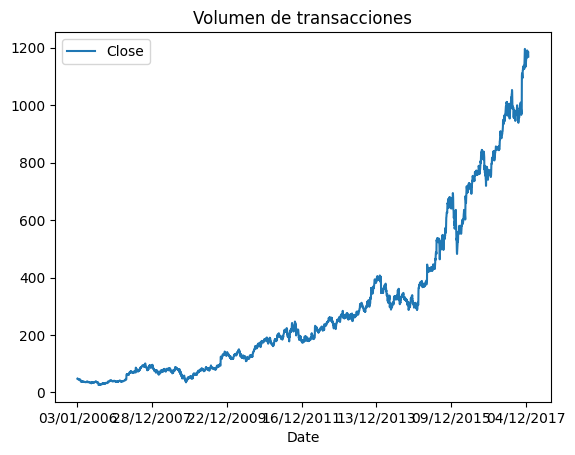

In [91]:
data[data['Name']=='AMZN'].plot(x='Date', y='Close', title='Volumen de transacciones')

In [ ]:
# Asegúrate de que tu modelo esté en modo eval
model.eval()

all_preds = []
all_targets = []

# Iteramos sobre el test_dataloader
with torch.no_grad():
    for batch in data_module.test_dataloader():
        features, targets = batch
        # features: [batch_size, seq_len, 1] (o como sea tu input)
        # targets: [batch_size, horizon] (o [batch_size] si es un horizonte 1)
        
        preds = model(features)  # [batch_size, horizon] o [batch_size]
        
        # Guardamos predicciones y targets
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenamos todos los batch para tener un solo tensor
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Si es horizonte 1:
# all_preds: [N], all_targets: [N]
# Si es horizonte > 1, puedes elegir un paso en particular o hacer promedio
# Ej: tomamos el primer paso:
if len(all_preds.shape) > 1:  # horizonte > 1
    all_preds = all_preds[:, 0]
    all_targets = all_targets[:, 0]

all_preds = all_preds.numpy()
all_targets = all_targets.numpy()

# Ahora graficamos
plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Real')
plt.plot(all_preds, label='Predicción')
plt.title('Comparación de Predicción vs Real (Test)')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()


tensor([[ 0.0025, -0.0130, -0.0065],
        [ 0.0267,  0.0032,  0.0026],
        [ 0.0014, -0.0098,  0.0069],
        [ 0.0040, -0.0141, -0.0011],
        [-0.0046, -0.0219, -0.0033],
        [-0.0185, -0.0278, -0.0104],
        [-0.0204, -0.0258, -0.0098],
        [-0.0112, -0.0197, -0.0097],
        [-0.0156, -0.0226, -0.0053],
        [-0.0150, -0.0267, -0.0093],
        [-0.0159, -0.0236, -0.0104],
        [-0.0171, -0.0241, -0.0066],
        [-0.0117, -0.0258, -0.0104],
        [-0.0210, -0.0277, -0.0126],
        [-0.0209, -0.0283, -0.0103],
        [-0.0183, -0.0287, -0.0125],
        [-0.0205, -0.0275, -0.0123],
        [-0.0236, -0.0301, -0.0121],
        [-0.0160, -0.0278, -0.0128],
        [-0.0076, -0.0239, -0.0106],
        [-0.0220, -0.0312, -0.0123],
        [-0.0171, -0.0292, -0.0138],
        [-0.0251, -0.0308, -0.0141],
        [-0.0181, -0.0281, -0.0126],
        [-0.0163, -0.0281, -0.0114],
        [-0.0038, -0.0193, -0.0094],
        [-0.0082, -0.0176, -0.0050],
 

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [67]:
# Mean and variance for train set
print("Train Volume Mean:", data_module.train_df['Volume'].mean())
print("Train Volume Variance:", data_module.train_df['Volume'].var())

# Mean and variance for val set
print("Val Volume Mean:", data_module.val_df['Volume'].mean())
print("Val Volume Variance:", data_module.val_df['Volume'].var())

# Mean and variance for test set
print("Test Volume Mean:", data_module.test_df['Volume'].mean())
print("Test Volume Variance:", data_module.test_df['Volume'].var())


Train Volume Mean: 0.06224386458458731
Train Volume Variance: 0.003282136544897219
Val Volume Mean: 0.024593598476296163
Val Volume Variance: 0.0005386118807041858
Test Volume Mean: 0.027790050447887682
Test Volume Variance: 0.0003195052666290482


In [ ]:
STR2ACT = {
    'tanh' : nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu' : nn.ReLU,
    'gelu' : nn.GELU
}

class RNN(nn.Module):
    """
    Implementation of a Recurrent Neural Network

    __init__()
    input_size[int]: features per timestep, if > 1 is multivariate
    hidden_size[int]: hidden size, normally between (64, 2056)
    num_layers[int]: number of rnn stacked cells, if > 1 is DeepRNN, normally between (1, 8)
    bidirectional[bool]: if the rnn is bidirectional
    bias[bool]: if input linear layers have bias

    forward()
    x[torch.Tensor]: model input of size [batch_size, seq_len, input_size]
    h[torch.Tensor]: initial hidden state of size [batch_size, seq_len, input_size], if None it will be zeros
    """
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, bias=False, activation='tanh', p_drop=0.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.bias = bias
        self.p_drop = p_drop

        self.l2r = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # left to right RNN

        if bidirectional:
            self.r2l = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # right to left RNN

        self.activation = STR2ACT[activation]() # tanh by default


    def rnn_layer(self, input_layer=False):
        return nn.ModuleDict({
            'w_ih' : nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size, bias=self.bias),
            'w_hh' : nn.Linear(self.hidden_size, self.hidden_size),
            'drop' : nn.Dropout(self.p_drop)
        })
    
    def process_sequence(self, x, h, direction='l2r'):
        """
        In deep RNNs (num_layers > 1), hidden state is propagated as:
        - input hidden state of the next layer of the current timestep; h(l, t) -> h(l+1, t)
        - input hidden state of the current layer of the next timestep; h(l, t) -> h(l, t+1)
        """
        seq_len = x.size(0)
        layers = self.l2r if direction == 'l2r' else self.r2l

        output = []
        for t in range(seq_len):
            x_t = x[t] # input
            for l, layer in enumerate(layers):
                # h[l] here is the lth hidden state for t-1
                # when override it will be the lth hidden state for t
                h[l] = self.activation(
                    layer['w_ih'](x_t) + layer['w_hh'](h[l])
                )
                h[l] = layer['drop'](h[l]) # no dropout by default

                x_t = h[l] # also, it will be the input for the l+1th layer of t
            
            output.append(h[-1]) # final hidden state for timestep t
        
        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]

    def forward(self, x, h=None):
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        batch_size = x.size(1)

        if self.bidirectional:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((2, self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            h_l2r, h_r2l = h[0], h[1] # if h is passed in bidirectional it is assumed that the format is [2, num_layers, batch_size, hidden_size]
            
            l2r_output = self.process_sequence(x, h_l2r, direction='l2r')
            r2l_output = self.process_sequence(x.flip(dims=[-1]), h_r2l, direction='r2l')

            r2l_output = r2l_output.flip(dims=[-1]) # flip to get left to right context

            output = torch.cat([l2r_output, r2l_output], dim=-1) # [batch_size, seq_len, 2 * hidden_size]

        else:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            output = self.process_sequence(x, h, direction='l2r') # [batch_size, seq_len, hidden_size]
        
        return output
    
class LSTM(nn.Module):
    """
    I_t (input_gate): how much of the input is added to the internal state
    F_t (forget_gate): whether to keep the current memory state or flush it
    O_t (output_gate): wheter the memory cell should influence the output
    C_t (cell_gate): how much we take into account new data
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = [self.lstm_layer(input_layer=(l==0))for l in range(num_layers)]

        self.sigmoid = nn.Sigmoid() 
        self.tanh = nn.Tanh()
        
    def lstm_layer(self, input_layer=False):
        """
        self.hidden_size * 4 because we use the same linear layer for
        the four gates and then split the outputs
        """
        return nn.ModuleDict({
            'w_ih': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size * 4, bias=False),
            'w_hh': nn.Linear(self.hidden_size, self.hidden_size * 4),
        })

    def forward(self, x, h=None):
        """
        In deep LSTMs (num_layers > 1), hidden and internal state are propagated as:
        - h(t, l) -> h(t+1, l); h(t, l) -> h(t, l+1)
        - c(t, l) -> c(t+1, l); c(t, l) -> c(t, l+1)
        """
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        seq_len, batch_size, _ = x.size()

        if h is None: # by default, hidden and internal states are initialized to 0s
            h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x

        h, c = (h, h) # at first, internal state is a copy of the hidden state

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for l, layer in enumerate(self.layers):
                gates_proj = layer['w_ih'](x_t) + layer['w_hh'](h[l]) # [batch_size, hidden_size * 4]
                input_gate, forget_gate, output_gate, cell_gate = gates_proj.chunk(4, dim=1)

                input_gate = self.sigmoid(input_gate)
                forget_gate = self.sigmoid(forget_gate)
                output_gate = self.sigmoid(output_gate)
                cell_gate = self.tanh(cell_gate)

                c[l] = c[l] * forget_gate + input_gate * cell_gate
                h[l] = self.tanh(c[l]) * output_gate
                x_t = h[l]

            output.append(h[-1])

        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]
        
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = nn.ModuleList([self.gru_layer(input_layer=(i==0)) for i in range(num_layers)])

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def gru_layer(self, input_layer=False):
        """
        self.hidden_size * 2 because we use the same linear layer for
        computing the reset and update gate

        w_ch is the linear layer for computing the candidate hidden state
        """
        return nn.ModuleDict({
            'w_ig': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size * 2, bias=False), # input to reset and update gates
            'w_hg': nn.Linear(self.hidden_size, self.hidden_size * 2), # hidden state to reset and update gates
            'w_ih': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size, bias=False), # input to candidate hidden state
            'w_gh': nn.Linear(self.hidden_size, self.hidden_size) # reset gate * hidden state to candidate hidden state
        })
    
    def forward(self, x, h=None):
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        seq_len, batch_size, _ = x.size()

        if h is None: # by default, hidden and internal states are initialized to 0s
            h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x

        output = []

        for t in range(seq_len):
            x_t = x[t]
            for l, layer in enumerate(self.layers):
                gates_proj = layer['w_ig'](x_t) + layer['w_hg'](h[l])
                reset_gate, update_gate = gates_proj.chunk(2, dim=1)

                reset_gate = self.sigmoid(reset_gate)
                update_gate = self.sigmoid(update_gate)

                candidate_hidden_state = layer['w_gh'](reset_gate * h[l]) + layer['w_ih'](x_t)
                candidate_hidden_state = self.tanh(candidate_hidden_state)

                h[l] = ((1 - update_gate) * candidate_hidden_state) + (h[l] * update_gate)

                x_t = h[l]
            
            output.append(h[-1])

        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]

In [ ]:
input_size = 3
hidden_size = 128
num_layers = 3

batch_size = 2
seq_len = 10


model = RNN(input_size, hidden_size, num_layers=num_layers, bidirectional=True, bias=True, activation='relu', p_drop=0.1)

x = torch.randn(batch_size, seq_len, input_size)

x.size(), model(x).size()